
From MCMC
a           b           c
[4.464605011119965, 2.0158230020559413, -0.0009303317503342876]
[0.09091576036701036, 0.04326802614873038, 0.004228427094452964]
Covariance
ab:  -0.003426517430157018 ac:  0.0002916216687633208 bc:  -0.00017752334829495198
Acceptance Ratio
0.08523


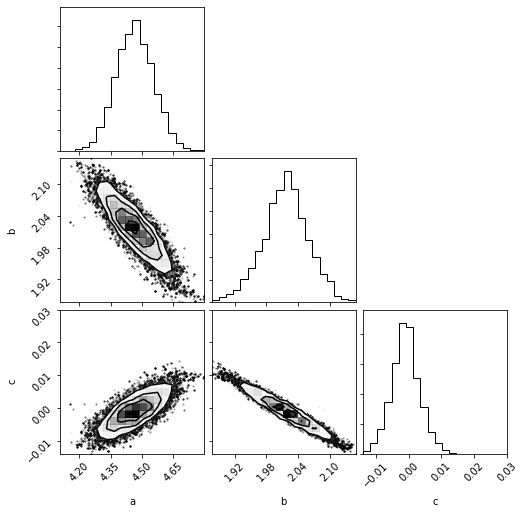

In [2]:
import pandas as pd
import numpy as np
from numpy import *
import numpy.random as nprd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import corner
import numpy.random as nprd

file1="E:/python/MDC_data_part_1.txt"
part1data=pd.read_csv(file1,header=None,sep='    ',engine='python')
part1data.columns=['x','y']
x=np.array(part1data['x'])
y=np.array(part1data['y'])
file2="E:/python/MDC_data_part_2.txt"
part2data=pd.read_csv(file2,header=None,sep='    ',engine='python')
part2data.columns=['x','y']
x2=np.array(part2data['x'])
y2=np.array(part2data['y'])

def linearfunc(x,a,b):
    return a+b*x
def quadraticfunc(x,a,b,c):
    return a+b*x+c*x**2
def stand_regres(x_mat, y_mat):
    x_mat_T = x_mat.T * x_mat
    reg_coef = linalg.solve(x_mat_T, x_mat.T * y_mat)  # 也可根据numpy中linalg模块中solve方法解ax + b = 0得到回归系数
    return reg_coef

popt,pcov=curve_fit(linearfunc,x,y)#直接使用scipy自带的最小二乘法拟合函数curvefit做线性回归
perr = np.sqrt(np.diag(pcov))
sigma=np.sqrt(np.var(y-linearfunc(x,popt[0],popt[1])))


##Specify length of MCMC chain
nmcmc = 100000

a = np.zeros(nmcmc)
b = np.zeros(nmcmc)
c = np.zeros(nmcmc)
sh = (nmcmc,3)
samples = np.zeros(sh)
chisq = np.zeros(nmcmc)

##Specify initial values, width of proposal density, and counter to compute acceptance ratio
accept = 0
a[0] = 4.2
samples[0,0] = 4.2
sig_a = 0.1
b[0] = 2.06
samples[0,1] = 2.06
sig_b = 0.05
samples[0,2] = 0.03
sig_c = 0.001
##Loop over the data points for chisquared calculation
for k in range(0,len(x)):
    chisq[0] = chisq[0] + ((y2[k]-(a[0]+b[0]*x2[k]+c[0]*x2[k]**2))/sigma)**2

##Go over points in the chain
for i in range(1,nmcmc):
    #print("Point "+str(i+1)+" of "+str(nmcmc), end="\r")

    ##Determine trial values
    a_trial = a[i-1] + sig_a*nprd.randn(1)
    b_trial = b[i-1] + sig_b*nprd.randn(1)
    c_trial = c[i-1] + sig_c*nprd.randn(1)

    ##Set initial value of chisq for trial point
    chisq_trial = 0

    ##Calculate the value of chisq for trial point
    #for k in range(0,len(x)):
     #   chisq_trial = chisq_trial + ((y[k]-(a_trial+b_trial*x[k]))/sigma)**2
    chisq_trial=np.sum(((a_trial+x*b_trial+c_trial*x**2-y)/sigma)**2)

    ##Calculate trial value of log ratio
    log_Lratio = 0.5*(chisq[i-1]-chisq_trial)

    ##Decide whether or not to accept trial value
    ##If trial point is "uphill" from previous point, accept it
    if log_Lratio >= 0:
        a[i] = a_trial
        b[i] = b_trial
        c[i] = c_trial
        samples[i,0] = a[i]
        samples[i,1] = b[i]
        samples[i,2] = c[i]
        chisq[i] = chisq_trial
        accept = accept + 1

    ##If it is not, calculate the actual likelihood ratio, then pick a random number and if bigger accept, if smaller set the point as the previous point in the Markov Chain
    else:
        ratio = np.exp(log_Lratio)
        test_uniform = nprd.rand(1)

        if test_uniform < ratio:
            a[i] = a_trial
            b[i] = b_trial
            c[i] = c_trial
            samples[i,0] = a[i]
            samples[i,1] = b[i]
            samples[i,2] = c[i]
            chisq[i] = chisq_trial
            accept = accept + 1

        else:
            a[i] = a[i-1]
            b[i] = b[i-1]
            c[i] = c[i-1]
            samples[i,0] = a[i]
            samples[i,1] = b[i]
            samples[i,2] = c[i]
            chisq[i] = chisq[i-1]

accept_ratio = accept/nmcmc


##Plotting and information

bar = [np.mean(a), np.mean(b),np.mean(c)]
err = [np.std(a), np.std(b),np.std(c)]

covariab = np.cov(a,b)[0,1]
covariac = np.cov(a,c)[0,1]
covaribc = np.cov(b,c)[0,1]
print("")
print("From MCMC")
print("a           b           c")
print(bar)
print(err)
print("Covariance")
print("ab: ",covariab,"ac: ",covariac,"bc: ",covaribc)
print("Acceptance Ratio")
print(accept_ratio)


fig = corner.corner(samples,labels=["a","b","c"])

fig.savefig("E:/python/MDC_data_part_2.png",dpi=500)